In [1]:
import pandas as pd
import numpy as np
import argparse
import itertools
import matplotlib.pyplot as plt

import re
import os
from os import path
import sys
import time

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/tmp/ipykernel_133113/3072613290.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Exeriment setup

4 nodes: 1 Job Manager, 1 Source, 1 Mapper, 1 Sink

## Hardware Info
```
16 Core Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz
Ethernet 10G 2P X520 Adapter
62 GB DRAM

hand32@Mapper10-3:~$ numactl -H -a
available: 2 nodes (0-1)
node 0 cpus: 0 1 2 3 4 5 6 7
node 0 size: 32137 MB
node 0 free: 27196 MB
node 1 cpus: 8 9 10 11 12 13 14 15
node 1 size: 32216 MB
node 1 free: 30765 MB
node distances:
node   0   1
  0:  10  21
  1:  21  10
```

## Flink Run Command
```
NITERS="2" FLINK_RATE="100000_600000" NSOURCES="16" NMAPPERS="4 16" NSINKS="16" ./run_query1.sh comboSMS
```

## Experiment details

```
Trying to lock down the reason behind the ~28% energy savings of using 16 mappers vs 4 mappers in Flink query1 for a rate of 100K RPS.

In this experiment, after waiting 180 seconds for the system to be saturated. I pinned the Mapper threads in both setups. For example in 4 mappers case, I pinned the tids in cores 15,14,13,12 and similarly for 16 mappers.

I also have the intlogger running in the background and in the results below I am taking the results between 180 seconds to 480 seconds of the entire run (600 seconds total).

I also collect the sleep state data, where for each core (0, 1, .. , 16) I collect the a set of statistics for each state (0, 1, 2, 3, 4) where state 0 is not sleeping and state 4 is deepest sleep state. For each of these states I collec the following information: above, below, time, usage, rejected, power. The description for each state can be found https://www.kernel.org/doc/html/v5.0/admin-guide/pm/cpuidle.html

The sleep states are collected every minute
```

# Experiment Analysis
Basic validations:
Total instructions between 4 and 16 mappers are basically the same - not a surprise as the amount of work is basically the same from the sames sources.

The per core instruction also illustrates the results of pinning where for the 4 mappers, cores 15,14,13,12 showed the largest instruction counts in contrast to other cores. 

Bytes received and transmitted are also similar between 4 mappers and 16 mappers - again similar work.

Interesting findings:
The number of interrupts is similarly different between 4 mappers and 16 mappers where the 16 mappers had less interrups than 4 mappers - suggests potentially 16 mappers had less busy cores than 4 mappers which makes sense as load is more evenly distributed.

The per-core receive and transmit bytes shows more bytes evenly distributed in 16 mappers vs 4 mappers.

For the sleep states, the only thing that really made sense is the
time: Total time spent in this idle state by the given CPU (as measured by the kernel) in microseconds.
It shows that for 4 mapper vs 16 mapper case: 
state4_time mapper4: 3619945458, mapper16: 3884532478, ratio (mapper4/mapper16) = 0.93
The deepest sleep state was able to idle about 7% longer for 16 mappers vs 4 mappers - this results in 28% energy savings?


In [2]:
df = pd.read_csv("cmp/combined.csv")
print(df.columns.tolist())

['Unnamed: 0', 'i', 'itr', 'dvfs', 'rate', 'policy', 'nmappers', 'SinknumRecordsInPerSecond_avg', 'SinknumRecordsInPerSecond_std', 'SinknumRecordsOutPerSecond_avg', 'SinknumRecordsOutPerSecond_std', 'SinkbusyTimeMsPerSecond_avg', 'SinkbusyTimeMsPerSecond_std', 'SinkbackPressuredTimeMsPerSecond_avg', 'SinkbackPressuredTimeMsPerSecond_std', 'SinkbusyTime_%', 'SinkbackPressuredTime_%', 'SourcenumRecordsInPerSecond_avg', 'SourcenumRecordsInPerSecond_std', 'SourcenumRecordsOutPerSecond_avg', 'SourcenumRecordsOutPerSecond_std', 'SourcebusyTimeMsPerSecond_avg', 'SourcebusyTimeMsPerSecond_std', 'SourcebackPressuredTimeMsPerSecond_avg', 'SourcebackPressuredTimeMsPerSecond_std', 'SourcebusyTime_%', 'SourcebackPressuredTime_%', 'MappernumRecordsInPerSecond_avg', 'MappernumRecordsInPerSecond_std', 'MappernumRecordsOutPerSecond_avg', 'MappernumRecordsOutPerSecond_std', 'MapperbusyTimeMsPerSecond_avg', 'MapperbusyTimeMsPerSecond_std', 'MapperbackPressuredTimeMsPerSecond_avg', 'MapperbackPressuredTim

## Data for Iteration 1

Joules diff between 16 mappers vs 4 mappers: 0.7202933985330073


/tmp/ipykernel_133113/1760029495.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f"Joules diff between 16 mappers vs 4 mappers: {int(df0[(df0.nmappers == 16)]['joules']) / int(df0[(df0.nmappers == 4)]['joules'])}")


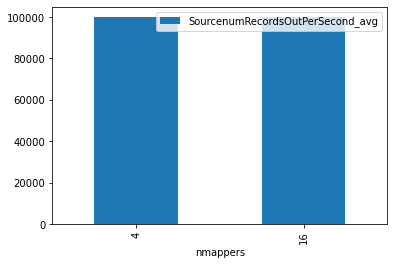

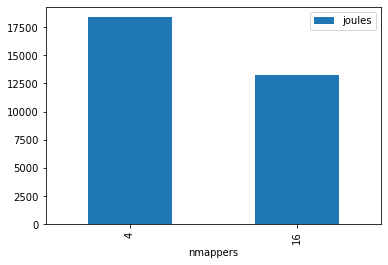

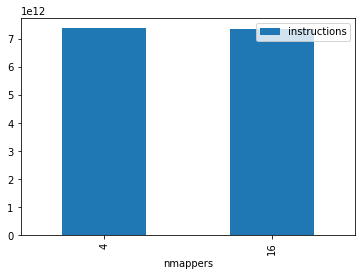

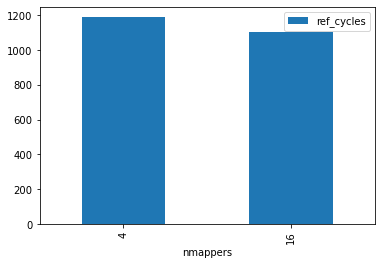

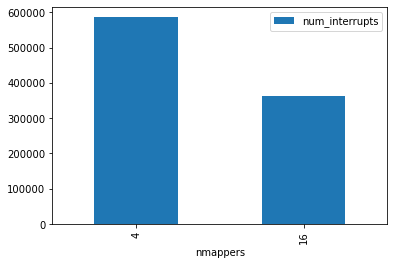

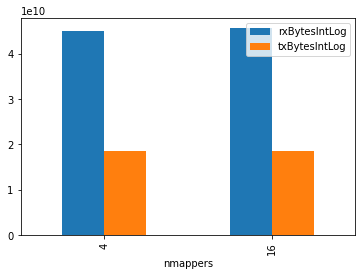

In [3]:
df0 = df[(df.i == 1)]
df0
df0.plot(x="nmappers", y=["SourcenumRecordsOutPerSecond_avg"], kind="bar") 
df0.plot(x="nmappers", y=["joules"], kind="bar") 
df0.plot(x="nmappers", y=["instructions"], kind="bar") 
df0.plot(x="nmappers", y=["ref_cycles"], kind="bar") 
df0.plot(x="nmappers", y=["num_interrupts"], kind="bar") 
df0.plot(x="nmappers", y=["rxBytesIntLog", "txBytesIntLog"], kind="bar") 
print(f"Joules diff between 16 mappers vs 4 mappers: {int(df0[(df0.nmappers == 16)]['joules']) / int(df0[(df0.nmappers == 4)]['joules'])}")


In [4]:
# possible vals: core{core}_ 
#                           'rx_desc', 'rx_bytes', 'tx_desc', 'tx_bytes', 'instructions_diff', 
#                           'cycles_diff', 'ref_cycles_diff', 'llc_miss_diff'
#                           num_interrupts
def plotMC(name, df):
    ys=[]
    for core in range(0, 16):
        ys.append(f"core{core}_{name}")
    df.plot(x="nmappers", y=ys, kind="bar", legend=False, title=name) 

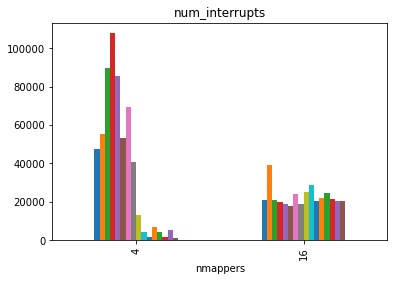

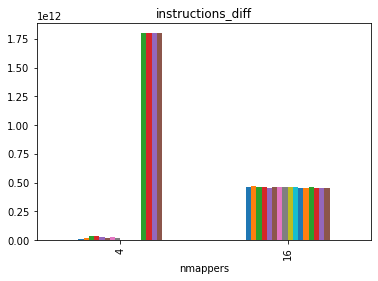

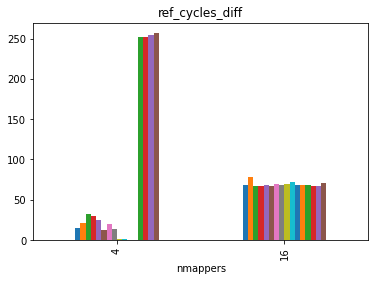

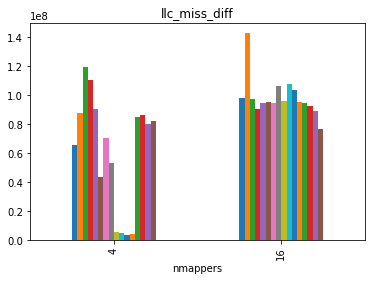

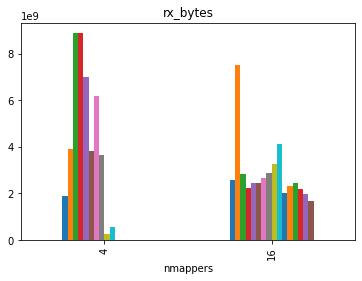

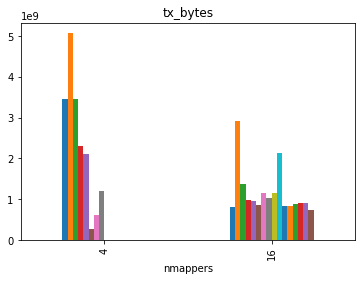

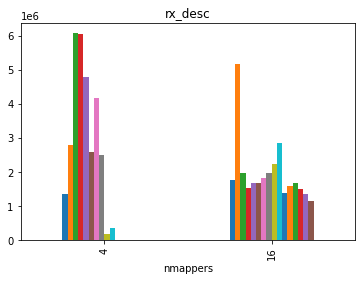

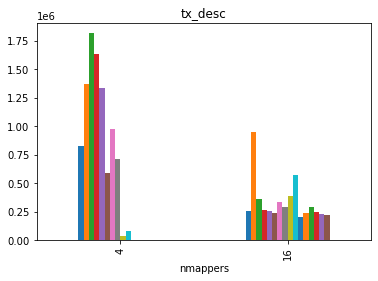

In [5]:
plotMC('num_interrupts', df0)
plotMC('instructions_diff', df0)
plotMC('ref_cycles_diff', df0)
plotMC('llc_miss_diff', df0)
plotMC('rx_bytes', df0)
plotMC('tx_bytes', df0)
plotMC('rx_desc', df0)
plotMC('tx_desc', df0)

In [6]:
#core10_state0_below
# possible vals: core{core}_ 
#                           'rx_desc', 'rx_bytes', 'tx_desc', 'tx_bytes', 'instructions_diff', 
#                           'cycles_diff', 'ref_cycles_diff', 'llc_miss_diff'
#                           num_interrupts
def plotCS(state, name, axes, df, r=0):
    ys=[]
    for core in range(0, 16):
        ys.append(f"core{core}_state{state}_{name}")
    df.plot(x="nmappers", y=ys, kind="bar", fontsize=22, legend=False, title=f"state{state}_{name}", ax=axes[r, state]) 


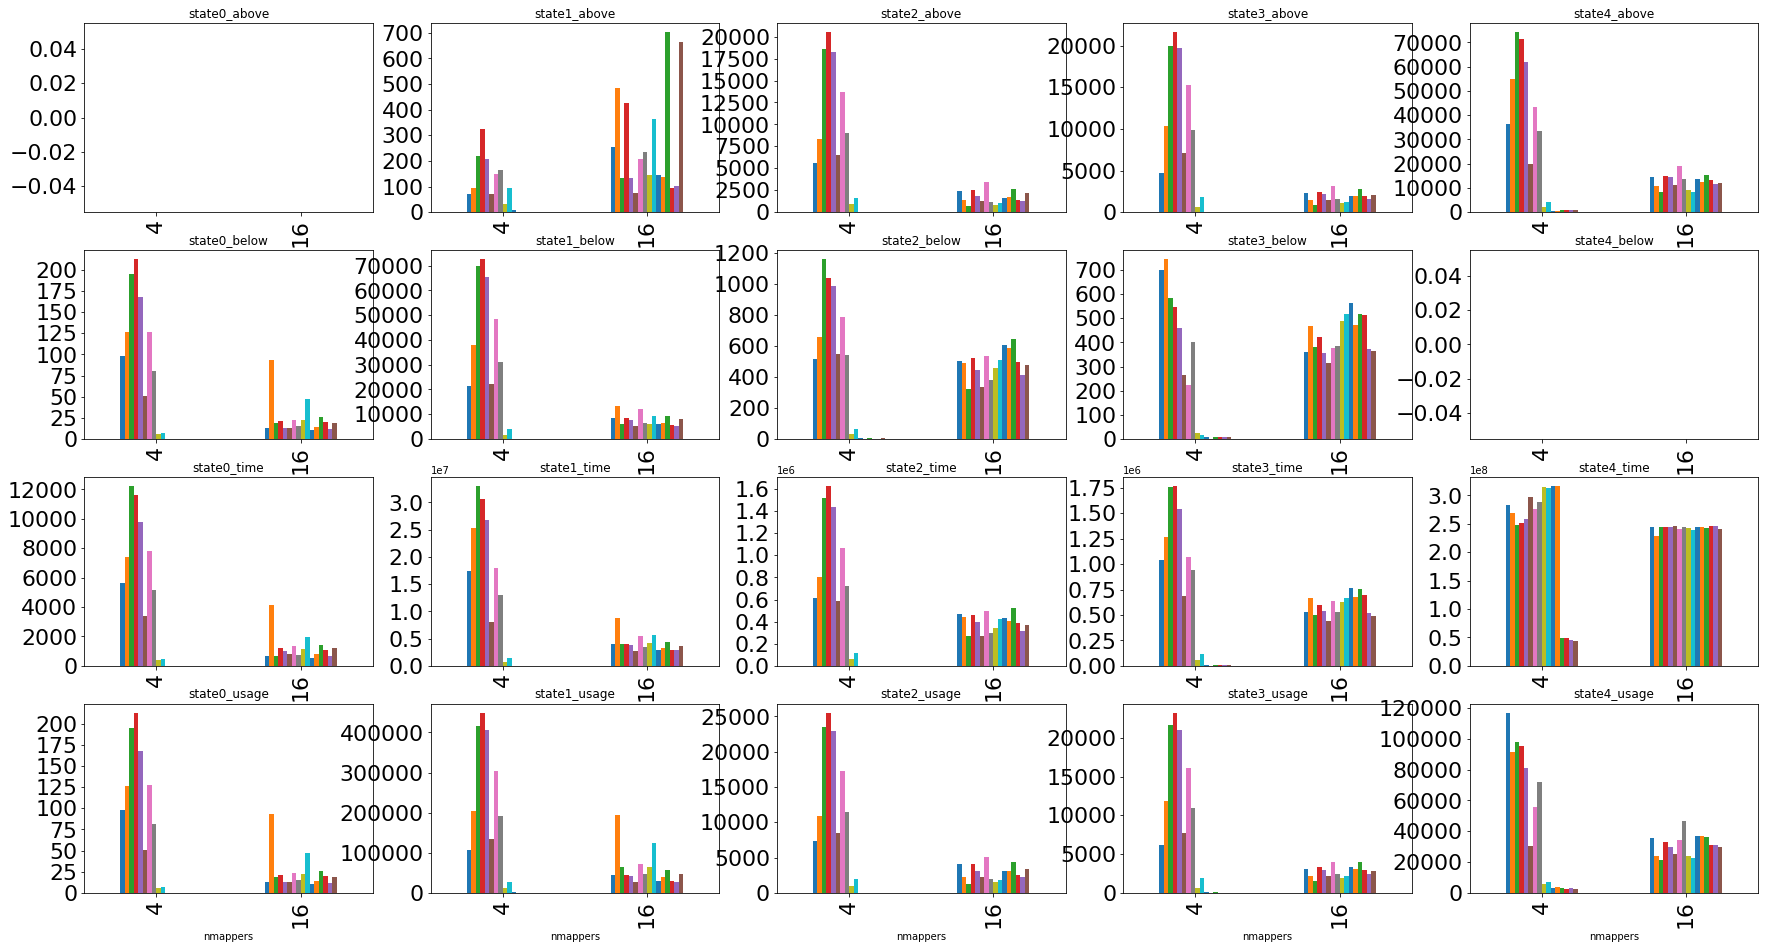

In [7]:

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(30,16))

#df1.plot(ax=axes[0,0])
#df2.plot(ax=axes[0,1])

plotCS(0, "above", axes, df0)
plotCS(1, "above", axes, df0)
plotCS(2, "above", axes, df0)
plotCS(3, "above", axes, df0)
plotCS(4, "above", axes, df0)

plotCS(0, "below", axes, df0, 1)
plotCS(1, "below", axes, df0, 1)
plotCS(2, "below", axes, df0, 1)
plotCS(3, "below", axes, df0, 1)
plotCS(4, "below", axes, df0, 1)

plotCS(0, "time", axes, df0, 2)
plotCS(1, "time", axes, df0, 2)
plotCS(2, "time", axes, df0, 2)
plotCS(3, "time", axes, df0, 2)
plotCS(4, "time", axes, df0, 2)

plotCS(0, "usage", axes, df0, 3)
plotCS(1, "usage", axes, df0, 3)
plotCS(2, "usage", axes, df0, 3)
plotCS(3, "usage", axes, df0, 3)
plotCS(4, "usage", axes, df0, 3)

In [8]:
for state in range(0, 5):
    dfmapper4 = df0[(df0.nmappers == 4)]
    dfmapper16 = df0[(df0.nmappers == 16)]
    
    mapper4 = 0
    mapper16 = 0

    for core in range(0, 16):
        mapper4 += int(dfmapper4[f"core{core}_state{state}_time"])
        mapper16 += int(dfmapper16[f"core{core}_state{state}_time"])
    print(f"state{state}_time mapper4: {mapper4}, mapper16: {mapper16}, ratio (mapper4/mapper16) = {round(mapper4/mapper16,2)}")

print("")
for state in range(0, 5):
    dfmapper4 = df0[(df0.nmappers == 4)]
    dfmapper16 = df0[(df0.nmappers == 16)]
    
    mapper4 = 0
    mapper16 = 0

    for core in range(0, 16):
        mapper4 += int(dfmapper4[f"core{core}_state{state}_usage"])
        mapper16 += int(dfmapper16[f"core{core}_state{state}_usage"])
    print(f"state{state}_usage mapper4: {mapper4}, mapper16: {mapper16}, ratio (mapper4/mapper16) = {round(mapper4/mapper16,2)}")


state0_time mapper4: 63866, mapper16: 19394, ratio (mapper4/mapper16) = 3.29
state1_time mapper4: 174665918, mapper16: 66518601, ratio (mapper4/mapper16) = 2.63
state2_time mapper4: 8552619, mapper16: 6297918, ratio (mapper4/mapper16) = 1.36
state3_time mapper4: 10293958, mapper16: 9632149, ratio (mapper4/mapper16) = 1.07
state4_time mapper4: 3619945458, mapper16: 3884532478, ratio (mapper4/mapper16) = 0.93

state0_usage mapper4: 1072, mapper16: 381, ratio (mapper4/mapper16) = 2.81
state1_usage mapper4: 2253186, mapper16: 953515, ratio (mapper4/mapper16) = 2.36
state2_usage mapper4: 130296, mapper16: 45874, ratio (mapper4/mapper16) = 2.84
state3_usage mapper4: 121501, mapper16: 44243, ratio (mapper4/mapper16) = 2.75
state4_usage mapper4: 671221, mapper16: 499119, ratio (mapper4/mapper16) = 1.34


/tmp/ipykernel_133113/2028017893.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  mapper4 += int(dfmapper4[f"core{core}_state{state}_time"])
/tmp/ipykernel_133113/2028017893.py:10: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  mapper16 += int(dfmapper16[f"core{core}_state{state}_time"])
/tmp/ipykernel_133113/2028017893.py:22: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  mapper4 += int(dfmapper4[f"core{core}_state{state}_usage"])
/tmp/ipykernel_133113/2028017893.py:23: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  mapper16 += int(dfmapper16[f"core{core}_state{state}_usage"])


## Data for Iteration 2

Joules diff between 16 mappers vs 4 mappers: 0.7364159965224951


/tmp/ipykernel_133113/322834622.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f"Joules diff between 16 mappers vs 4 mappers: {int(df0[(df0.nmappers == 16)]['joules']) / int(df0[(df0.nmappers == 4)]['joules'])}")


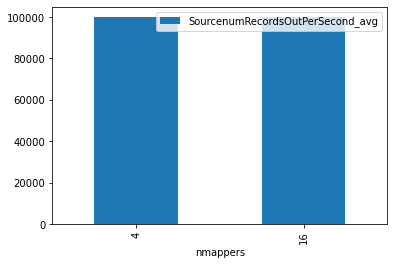

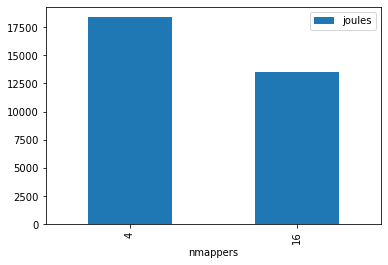

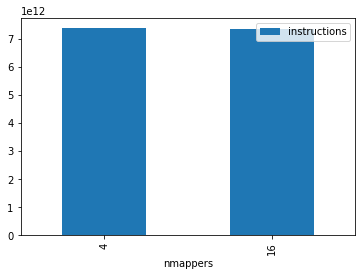

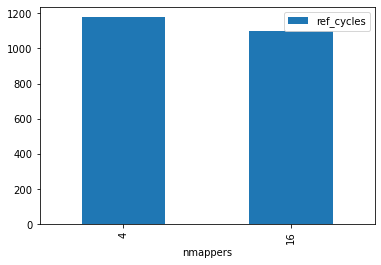

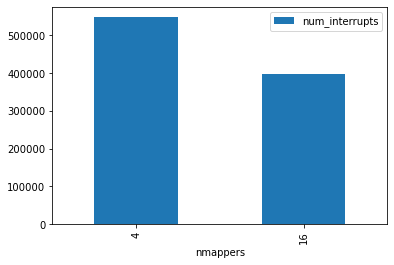

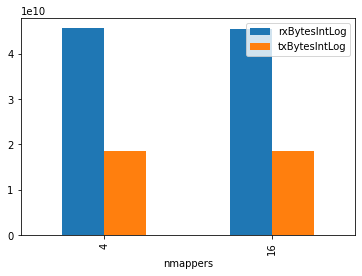

In [9]:
df0 = df[(df.i == 2)]
df0
df0.plot(x="nmappers", y=["SourcenumRecordsOutPerSecond_avg"], kind="bar") 
df0.plot(x="nmappers", y=["joules"], kind="bar") 
df0.plot(x="nmappers", y=["instructions"], kind="bar") 
df0.plot(x="nmappers", y=["ref_cycles"], kind="bar") 
df0.plot(x="nmappers", y=["num_interrupts"], kind="bar") 
df0.plot(x="nmappers", y=["rxBytesIntLog", "txBytesIntLog"], kind="bar") 
print(f"Joules diff between 16 mappers vs 4 mappers: {int(df0[(df0.nmappers == 16)]['joules']) / int(df0[(df0.nmappers == 4)]['joules'])}")



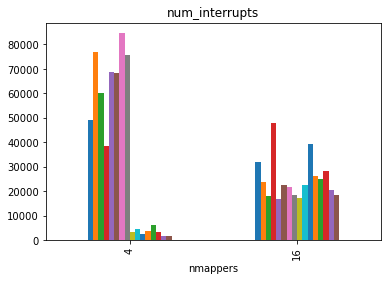

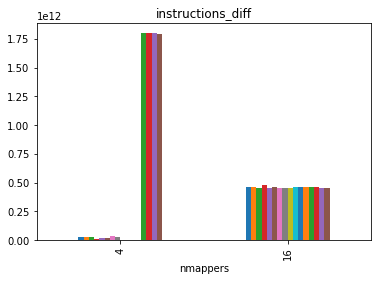

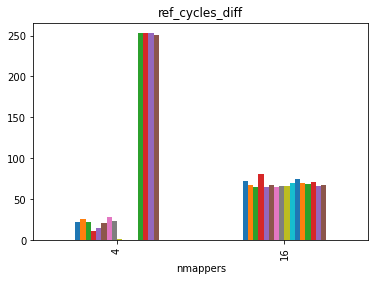

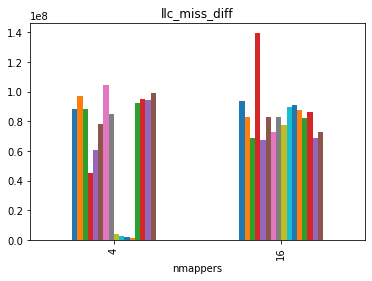

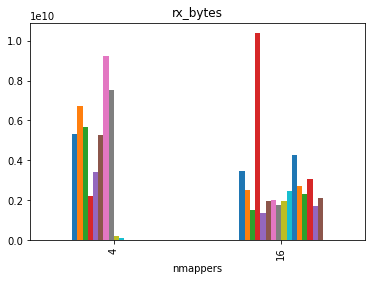

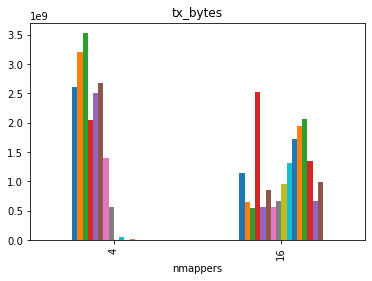

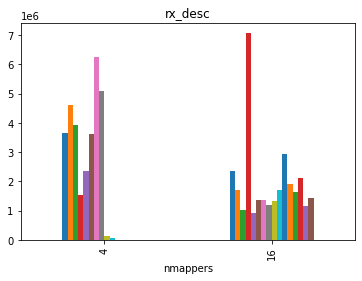

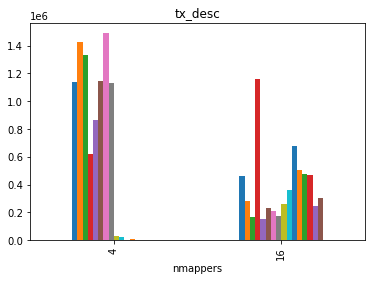

In [10]:
plotMC('num_interrupts', df0)
plotMC('instructions_diff', df0)
plotMC('ref_cycles_diff', df0)
plotMC('llc_miss_diff', df0)
plotMC('rx_bytes', df0)
plotMC('tx_bytes', df0)
plotMC('rx_desc', df0)
plotMC('tx_desc', df0)

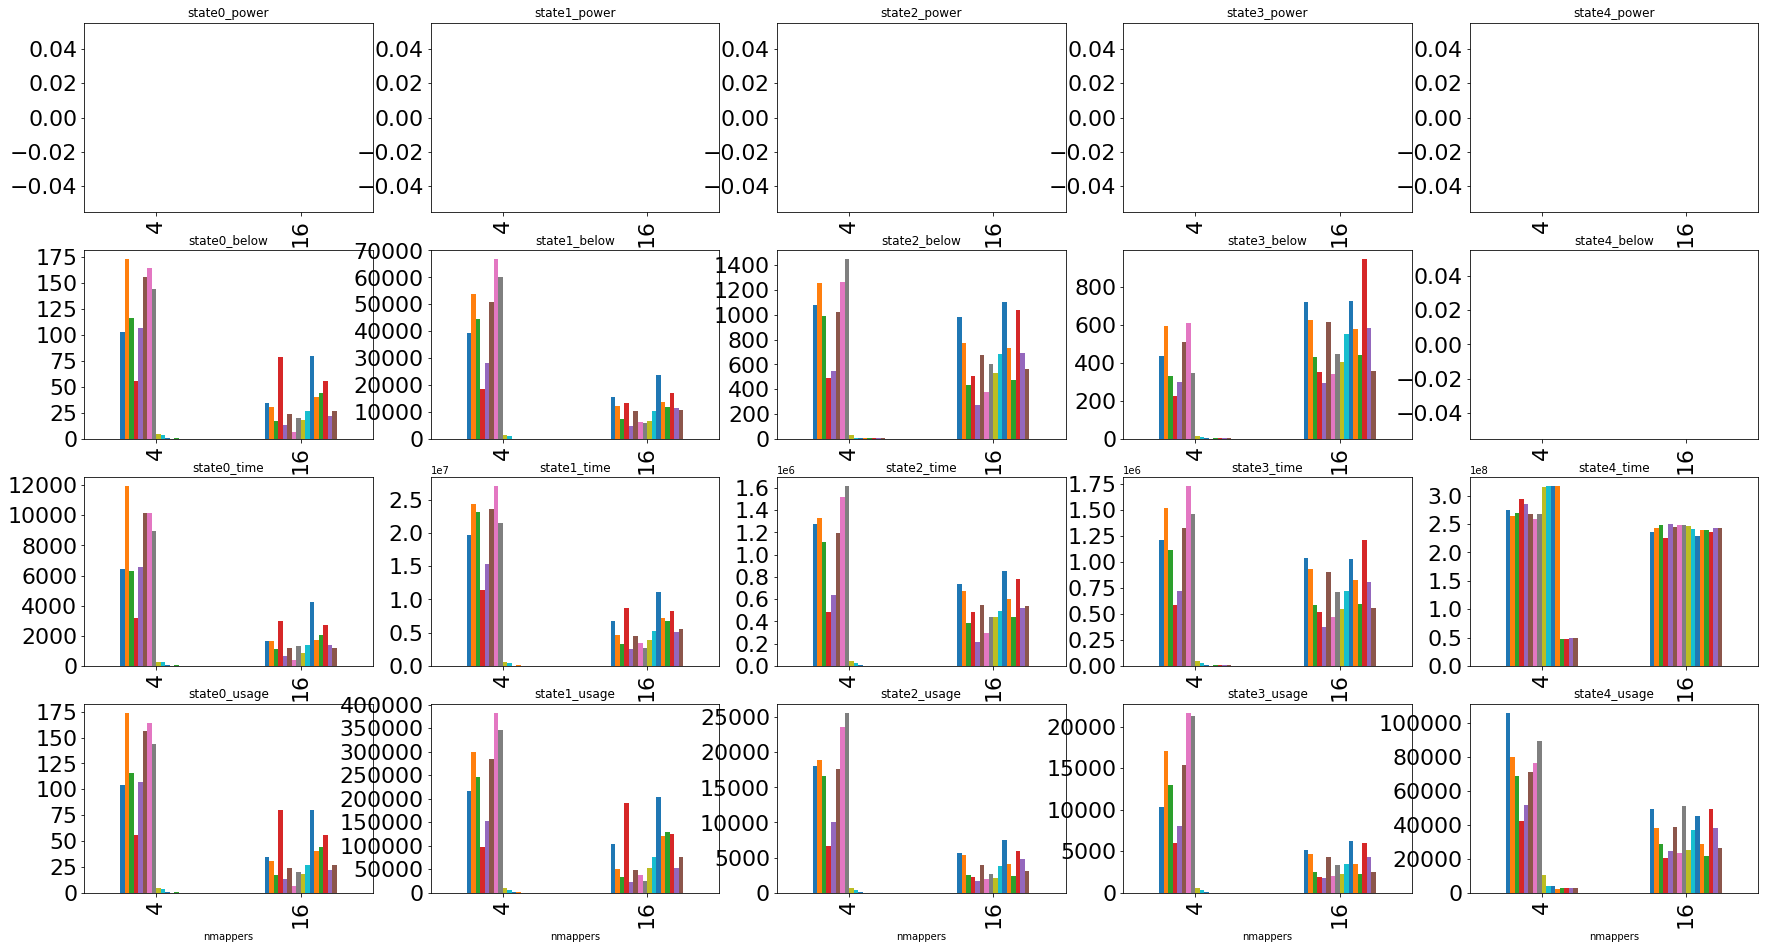

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(30,16))

plotCS(0, "power", axes, df0)
plotCS(1, "power", axes, df0)
plotCS(2, "power", axes, df0)
plotCS(3, "power", axes, df0)
plotCS(4, "power", axes, df0)

plotCS(0, "below", axes, df0, 1)
plotCS(1, "below", axes, df0, 1)
plotCS(2, "below", axes, df0, 1)
plotCS(3, "below", axes, df0, 1)
plotCS(4, "below", axes, df0, 1)

plotCS(0, "time", axes, df0, 2)
plotCS(1, "time", axes, df0, 2)
plotCS(2, "time", axes, df0, 2)
plotCS(3, "time", axes, df0, 2)
plotCS(4, "time", axes, df0, 2)

plotCS(0, "usage", axes, df0, 3)
plotCS(1, "usage", axes, df0, 3)
plotCS(2, "usage", axes, df0, 3)
plotCS(3, "usage", axes, df0, 3)
plotCS(4, "usage", axes, df0, 3)

In [12]:
for state in range(0, 5):
    dfmapper4 = df0[(df0.nmappers == 4)]
    dfmapper16 = df0[(df0.nmappers == 16)]
    
    mapper4 = 0
    mapper16 = 0

    for core in range(0, 16):
        mapper4 += int(dfmapper4[f"core{core}_state{state}_time"])
        mapper16 += int(dfmapper16[f"core{core}_state{state}_time"])
    print(f"state{state}_time mapper4: {mapper4}, mapper16: {mapper16}, ratio (mapper4/mapper16) = {round(mapper4/mapper16,2)}")

print("")
for state in range(0, 5):
    dfmapper4 = df0[(df0.nmappers == 4)]
    dfmapper16 = df0[(df0.nmappers == 16)]
    
    mapper4 = 0
    mapper16 = 0

    for core in range(0, 16):
        mapper4 += int(dfmapper4[f"core{core}_state{state}_usage"])
        mapper16 += int(dfmapper16[f"core{core}_state{state}_usage"])
    print(f"state{state}_usage mapper4: {mapper4}, mapper16: {mapper16}, ratio (mapper4/mapper16) = {round(mapper4/mapper16,2)}")


state0_time mapper4: 64374, mapper16: 26671, ratio (mapper4/mapper16) = 2.41
state1_time mapper4: 167322250, mapper16: 89584324, ratio (mapper4/mapper16) = 1.87
state2_time mapper4: 9262420, mapper16: 8428370, ratio (mapper4/mapper16) = 1.1
state3_time mapper4: 9783541, mapper16: 11832393, ratio (mapper4/mapper16) = 0.83
state4_time mapper4: 3639136837, mapper16: 3855267060, ratio (mapper4/mapper16) = 0.94

state0_usage mapper4: 1032, mapper16: 541, ratio (mapper4/mapper16) = 1.91
state1_usage mapper4: 2042663, mapper16: 1350164, ratio (mapper4/mapper16) = 1.51
state2_usage mapper4: 138146, mapper16: 59969, ratio (mapper4/mapper16) = 2.3
state3_usage mapper4: 113741, mapper16: 56128, ratio (mapper4/mapper16) = 2.03
state4_usage mapper4: 616609, mapper16: 545302, ratio (mapper4/mapper16) = 1.13


/tmp/ipykernel_133113/2028017893.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  mapper4 += int(dfmapper4[f"core{core}_state{state}_time"])
/tmp/ipykernel_133113/2028017893.py:10: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  mapper16 += int(dfmapper16[f"core{core}_state{state}_time"])
/tmp/ipykernel_133113/2028017893.py:22: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  mapper4 += int(dfmapper4[f"core{core}_state{state}_usage"])
/tmp/ipykernel_133113/2028017893.py:23: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  mapper16 += int(dfmapper16[f"core{core}_state{state}_usage"])
